# **Messi outlier**
## Assists

The aim of this notebook is to assess whether Messi’s assists performance can be considered an outlier when compared to other top goalscorers.
An assist refers to a pass that directly sets up a teammate to score a goal.

### Datasets
We use `dataset2_player_performances.parquet` & `dataset2_player_profiles`

- `dataset2_player_performances.parquet`: provides football player performances
- `dataset2_player_profiles`: provides football player names and other personal attributes

We merge the performance and profiles dataset using player_id as link

**Resulting dataset: `merged_player_data.parquet`**

In [1]:
import pandas as pd

# Load datasets (go up one level from notebooks/ to reach data/)
df_perf = pd.read_parquet("../data/dataset2_player_performances.parquet")
df_profiles = pd.read_parquet("../data/dataset2_player_profiles.parquet")

# Merge on player_id
df_merged = df_perf.merge(df_profiles, on="player_id", how="left")

# Save the merged dataset back into data/ or notebooks/
df_merged.to_parquet("../data/merged_player_data.parquet", index=False)

### We now focus on `assists` variable

In [2]:
import pandas as pd

# Load merged dataset
df_merged = pd.read_parquet("../data/merged_player_data.parquet")

# Aggregate total assists per player and sort
top_assisters = (
    df_merged.groupby("player_name", as_index=False)["assists"]
    .sum()
    .sort_values("assists", ascending=False)
)

# Shape of the aggregated data
print("Shape (rows, columns):", top_assisters.shape)

# Show the first rows
top_assisters.head(20)

Shape (rows, columns): (87891, 2)


,player_name,assists
47961,Lionel Messi (28003),368
79594,Thomas Müller (58358),281
87298,Ángel Di María (45320),278
50157,Luis Suárez (44352),277
72706,Ryan Giggs (3406),269
21443,Dušan Tadić (36139),267
44829,Kevin De Bruyne (88755),261
15601,Cristiano Ronaldo (8198),257
33900,Hulk (80562),231
62088,Neymar (68290),227


## Building the Assists Viz

### 1) Data prep chunk

In [3]:
import numpy as np
import pandas as pd

# --- Load & basic hygiene ---
df_merged = pd.read_parquet("../data/merged_player_data.parquet").copy()
# Ensure assists/goals are numeric (robust to weird types)
for col in ["assists", "goals"]:
    if col in df_merged.columns:
        df_merged[col] = pd.to_numeric(df_merged[col], errors="coerce").fillna(0)

# --- Load & aggregate (career totals per player) ---
agg_all = (
    df_merged.groupby("player_name", as_index=False)[["assists", "goals"]]
             .sum()
             .rename(columns={"assists": "value"})   # <-- rank by ASSISTS now
)
agg_all["ga_total"] = agg_all["value"] + agg_all["goals"]  # total (assists + goals), optional
agg_assists = agg_all[agg_all["value"] > 0].copy()         # Players with ≥1 assist

# --- Find Messi (handles optional id suffix like " (28003)") ---
m = agg_all["player_name"].str.contains(r"^Lionel Messi(?:\s*\(\d+\))?$",
                                        case=False, na=False)
messi_name = agg_all.loc[m, "player_name"].iloc[0] if m.any() else None

# --- Cohorts: Top-N assisters across ALL players ---
def topN_assisters(df_agg: pd.DataFrame, N: int) -> pd.DataFrame:
    top_names = set(df_agg.sort_values("value", ascending=False).head(N)["player_name"])
    if messi_name is not None:
        top_names.add(messi_name)  # force-include Messi
    return df_agg[df_agg["player_name"].isin(top_names)].copy()

agg_top1000 = topN_assisters(agg_all, 1000)
agg_top500  = topN_assisters(agg_all, 500)
agg_top100  = topN_assisters(agg_all, 100)
agg_top10   = topN_assisters(agg_all, 10)

# --- Build combined DF with row labels (for plotting/faceting) ---
def prep_block(df: pd.DataFrame, row_label: str) -> pd.DataFrame:
    out = df.loc[:, ["player_name", "value"]].copy()  # 'value' = total assists
    out["row"] = row_label
    out["is_messi"] = (out["player_name"] == messi_name)
    return out

df_plot = pd.concat(
    [
        prep_block(agg_assists, "All assisters"),
        prep_block(agg_top1000, "Top-1000 assisters"),
        prep_block(agg_top500,  "Top-500 assisters"),
        prep_block(agg_top100,  "Top-100 assisters"),
        prep_block(agg_top10,   "Top-10 assisters"),
    ],
    ignore_index=True
)

# --- Jitter column for background dots (ONLY for plotting) ---
rng = np.random.default_rng(123)
mask_other = ~df_plot["is_messi"]
df_plot.loc[mask_other, "value_jit"] = (
    df_plot.loc[mask_other, "value"] + rng.uniform(-0.3, 0.3, mask_other.sum())
)
df_plot.loc[~mask_other, "value_jit"] = df_plot.loc[~mask_other, "value"]

# --- Quick peek: Top 1000 assisters table (optional) ---
top1000_assisters = agg_top1000.sort_values("value", ascending=False).reset_index(drop=True)
top1000_assisters.head(20)

,player_name,value,goals,ga_total
0,Lionel Messi (28003),368,771.0,1139.0
1,Thomas Müller (58358),281,293.0,574.0
2,Ángel Di María (45320),278,200.0,478.0
3,Luis Suárez (44352),277,509.0,786.0
4,Ryan Giggs (3406),269,168.0,437.0
5,Dušan Tadić (36139),267,232.0,499.0
6,Kevin De Bruyne (88755),261,156.0,417.0
7,Cristiano Ronaldo (8198),257,796.0,1053.0
8,Hulk (80562),231,434.0,665.0
9,Neymar (68290),227,366.0,593.0


### 2) Viz chunk

#### Beeswarm plot

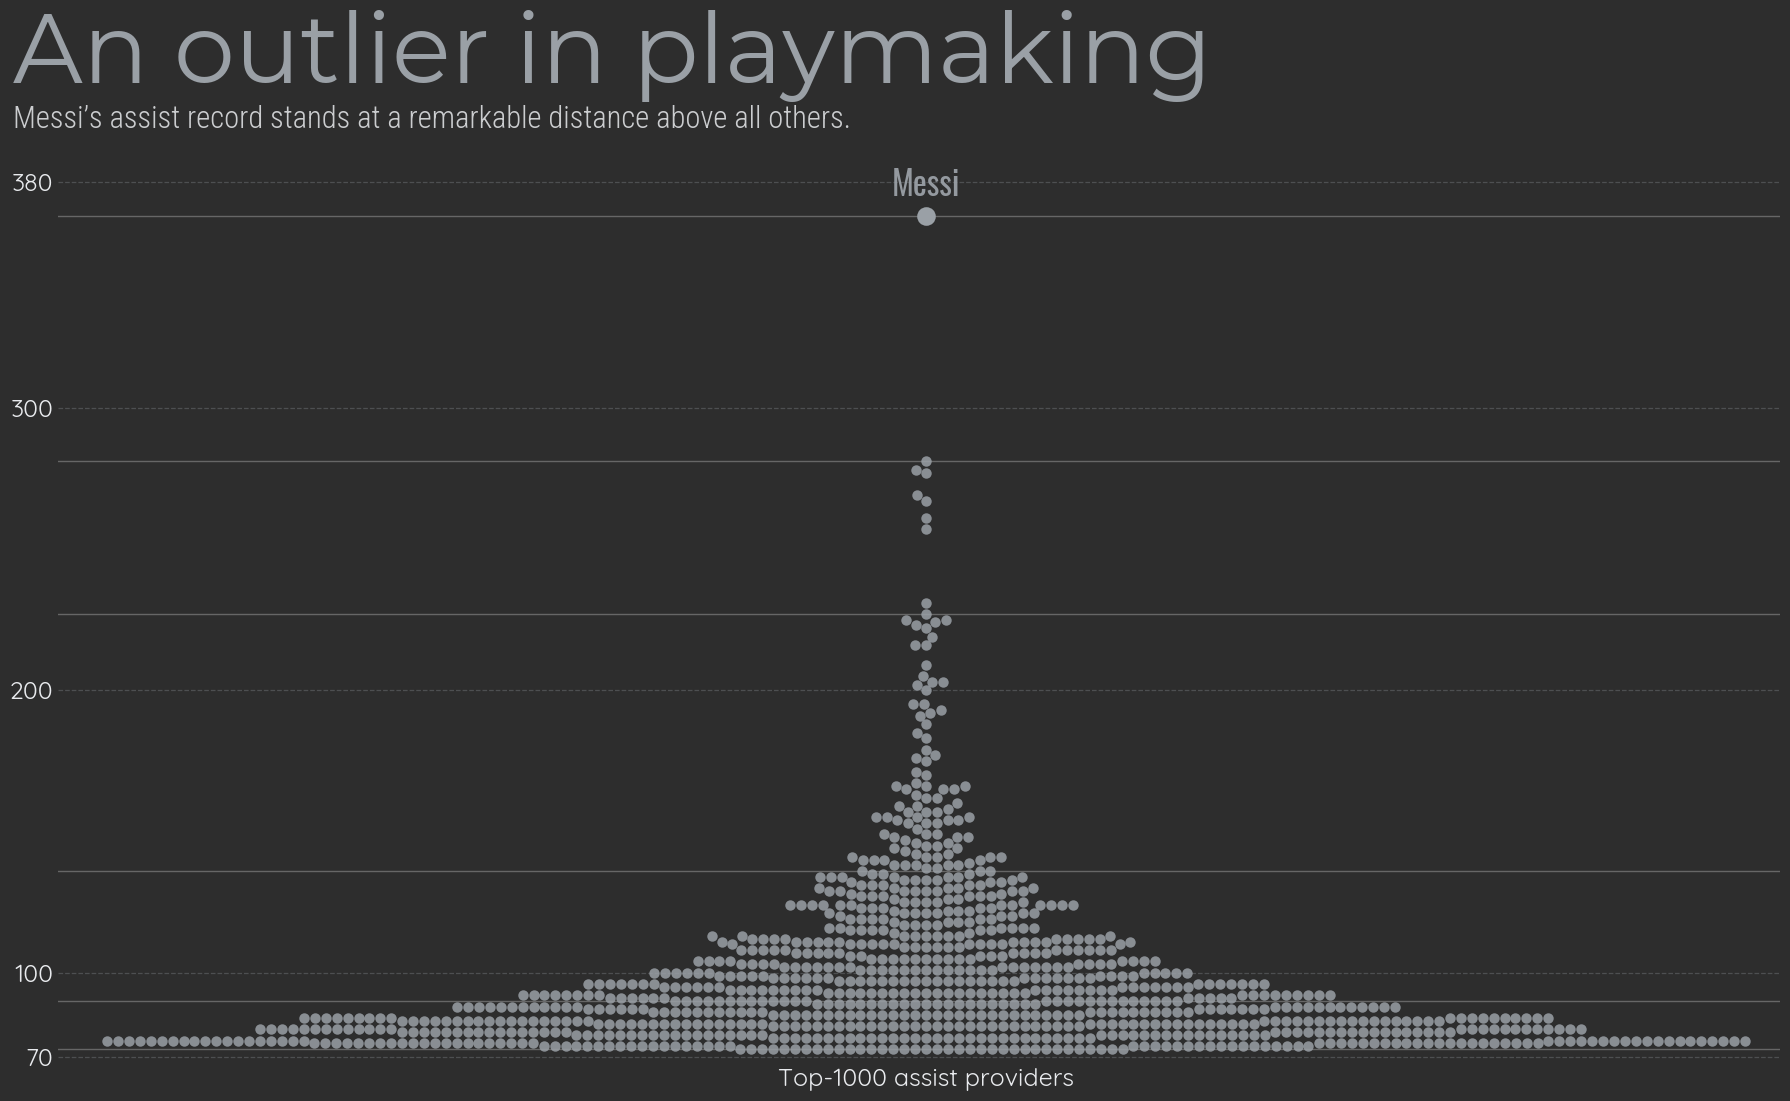

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from pyfonts import load_font

# Fonts (for labels/title)
oswald = load_font("https://github.com/google/fonts/raw/main/ofl/oswald/Oswald%5Bwght%5D.ttf")
quick_reg = load_font("/Users/andresdevegili/Documents/fonts/Quicksand/static/Quicksand-Regular.ttf")
montserrat_reg = load_font("/Users/andresdevegili/Documents/fonts/Montserrat/static/Montserrat-Regular.ttf")
instrument = load_font("https://github.com/google/fonts/raw/main/ofl/instrumentserif/InstrumentSerif-Regular.ttf")
roboto_cond_light = load_font("/Users/andresdevegili/Documents/fonts/Roboto/static/Roboto_Condensed-Light.ttf")
COHORT_COLOR = "#9AA0A6"   # gray dots
MESSI_COLOR  = "#9AA0A6"   # cyan highlight

# ---------------------------
# Data prep
# ---------------------------
ASSISTS_MIN = 1
df_merged = pd.read_parquet("../data/merged_player_data.parquet").copy()
for col in ["goals", "assists"]:
    if col in df_merged.columns:
        df_merged[col] = pd.to_numeric(df_merged[col], errors="coerce").fillna(0)

df_merged["main_position"] = df_merged["main_position"].astype(str).str.strip().str.title()

def mode_or_first(s: pd.Series) -> str:
    vals = [v for v in s.dropna().tolist() if v != ""]
    return (Counter(vals).most_common(1)[0][0]) if vals else "Unknown"

pos_per_player = (
    df_merged.groupby("player_name", as_index=False)["main_position"]
             .agg(mode_or_first)
             .rename(columns={"main_position": "main_position_mode"})
)

agg = (
    df_merged.groupby("player_name", as_index=False)[["goals", "assists"]].sum()
    .merge(pos_per_player, on="player_name", how="left")
)
agg["ga_total"] = agg["goals"] + agg["assists"]
agg = agg[agg["assists"] >= ASSISTS_MIN].copy()

messi_pat  = re.compile(r"^Lionel Messi(?:\s*\(\d+\))?$", re.IGNORECASE)
messi_rows = agg[agg["player_name"].str.contains(messi_pat, na=False)]
messi_name = messi_rows["player_name"].iloc[0] if not messi_rows.empty else None

def topN(df_in: pd.DataFrame, N: int) -> pd.DataFrame:
    top_names = set(df_in.sort_values("assists", ascending=False).head(N)["player_name"])
    if messi_name is not None:
        top_names.add(messi_name)
    return df_in[df_in["player_name"].isin(top_names)].copy()

df_top1000 = topN(agg, 1000)

df_plot = (
    df_top1000.loc[:, ["player_name", "assists"]]
              .rename(columns={"assists": "value"})
              .copy()
)
df_plot["cohort"]   = "Top-1000"
df_plot["is_messi"] = (df_plot["player_name"] == messi_name)

# ---------------------------
# Shared scaling (Y axis = assists)
# ---------------------------
YMIN = 68                             # consistent lower bound used before
YMAX = max(380, df_plot["value"].max())
YTICKS = [70, 100, 200, 300, 380]     # fixed tick set

# ---------------------------
# Plot — Beeswarm only
# ---------------------------
fig, ax = plt.subplots(figsize=(18, 10))
fig.patch.set_facecolor("#2d2d2d")
ax.set_facecolor("#2d2d2d")

sns.swarmplot(
    data=df_plot[~df_plot["is_messi"]],
    x="cohort", y="value",
    order=["Top-1000"],
    color=COHORT_COLOR,
    size=7.5, alpha=0.85, dodge=False, ax=ax
)

messi_pts = df_plot[df_plot["is_messi"]]
if not messi_pts.empty:
    ax.scatter(
        messi_pts["cohort"], messi_pts["value"],
        s=180, c=[MESSI_COLOR], zorder=3, linewidths=0
    )
    for y in messi_pts["value"]:
        ax.annotate(
            "Messi", xy=("Top-1000", y), xytext=(0, 10), textcoords="offset points",
            ha="center", va="bottom", color=MESSI_COLOR, fontsize=24,
            fontproperties=oswald, alpha=0.95, clip_on=False
        )

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("")
# Y limits & custom grid (shared formatting)
ax.set_ylim(YMIN, YMAX + 5)
ax.set_yticks(YTICKS)
ymin, ymax = ax.get_ylim(); eps = (ymax - ymin) * 1e-3
for ypos in YTICKS:
    yy = ypos - eps if np.isclose(ypos, ymax) else ypos
    ax.axhline(yy, color="#9aa0a6", alpha=0.3, linestyle="--", linewidth=0.9, zorder=0)

# X tick (single cohort)
ax.set_xticks([0])
ax.set_xticklabels(["Top-1000 assist providers"], fontproperties=quick_reg, fontsize=18, color="#e8eaed")

# Typography & clean look
for lab in ax.get_yticklabels():
    lab.set_fontproperties(quick_reg); lab.set_fontsize(18); lab.set_color("#e8eaed")
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False, bottom=False, labelleft=True, labelbottom=True, length=0)

# --- Custom gridlines at key assist values ---
assist_lines = [368, 281, 227, 136, 90, 73]  # Messi, 2nd, 10th, 100th, 500th, 1000th

# Draw horizontal gridlines at custom values
for ypos in assist_lines:
    ax.axhline(
        ypos,
        color="lightgray", alpha=0.35,
        linestyle="-", linewidth=1.0, zorder=0
    )


# Title & Subtitle (Messi Outlier collection: Assists)
fig.text(
    0.01, 1.004, "An outlier in playmaking",
    fontproperties=montserrat_reg, fontsize=70, color="#9AA0A6",
    ha="left", va="bottom"
)

fig.text(
    0.01, 1.001,
    "Messi’s assist record stands at a remarkable distance above all others.",
    fontproperties=roboto_cond_light, fontsize=22, color="#e8eaed", alpha=0.85,
    ha="left", va="top"
)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.savefig("../figs/messi_outlier_assists_beeswarmplot.svg", facecolor=fig.get_facecolor(), bbox_inches="tight")
plt.show()

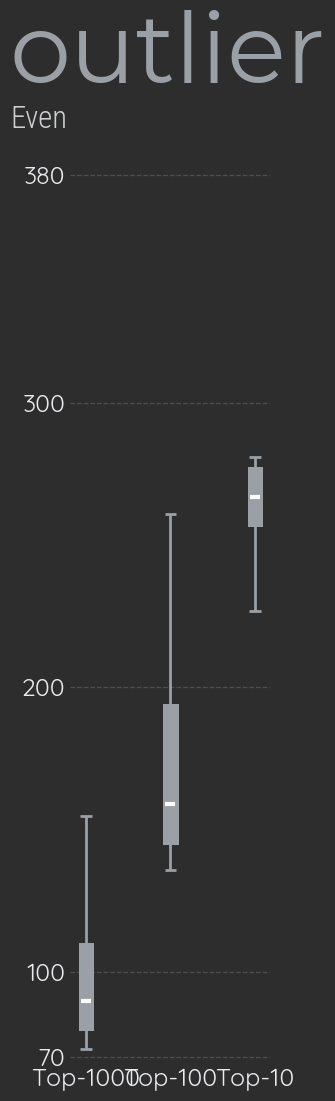

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import re
from collections import Counter
from pyfonts import load_font

# Fonts & colors (match chunk 1)
quick_reg = load_font("/Users/andresdevegili/Documents/fonts/Quicksand/static/Quicksand-Regular.ttf")
COHORT_COLOR = "#9AA0A6"   # same gray

# ---------------------------
# Data prep (same as chunk 1)
# ---------------------------
ASSISTS_MIN = 1
df_merged = pd.read_parquet("../data/merged_player_data.parquet").copy()
for col in ["goals", "assists"]:
    if col in df_merged.columns:
        df_merged[col] = pd.to_numeric(df_merged[col], errors="coerce").fillna(0)

df_merged["main_position"] = df_merged["main_position"].astype(str).str.strip().str.title()

def mode_or_first(s: pd.Series) -> str:
    vals = [v for v in s.dropna().tolist() if v != ""]
    return (Counter(vals).most_common(1)[0][0]) if vals else "Unknown"

pos_per_player = (
    df_merged.groupby("player_name", as_index=False)["main_position"]
             .agg(mode_or_first)
             .rename(columns={"main_position": "main_position_mode"})
)

agg = (
    df_merged.groupby("player_name", as_index=False)[["goals", "assists"]].sum()
    .merge(pos_per_player, on="player_name", how="left")
)
agg["ga_total"] = agg["goals"] + agg["assists"]
agg = agg[agg["assists"] >= ASSISTS_MIN].copy()

messi_pat  = re.compile(r"^Lionel Messi(?:\s*\(\d+\))?$", re.IGNORECASE)
messi_rows = agg[agg["player_name"].str.contains(messi_pat, na=False)]
messi_name = messi_rows["player_name"].iloc[0] if not messi_rows.empty else None

def topN(df_in: pd.DataFrame, N: int) -> pd.DataFrame:
    top_names = set(df_in.sort_values("assists", ascending=False).head(N)["player_name"])
    if messi_name is not None:
        top_names.add(messi_name)
    return df_in[df_in["player_name"].isin(top_names)].copy()

df_top1000 = topN(agg, 1000)
df_top100  = topN(agg, 100)
df_top10   = topN(agg, 10)

# Arrays for each cohort (exclude Messi for cohort distribution shape, like before)
vals_1000 = df_top1000.loc[df_top1000["player_name"] != messi_name, "assists"].to_numpy()
vals_100  = df_top100.loc[df_top100["player_name"]   != messi_name, "assists"].to_numpy()
vals_10   = df_top10.loc[df_top10["player_name"]     != messi_name, "assists"].to_numpy()

# ---------------------------
# Shared scaling (MATCH chunk 1)
# ---------------------------
YMIN = 68
YMAX = max(380, df_top1000["assists"].max())  # lock to Top-1000 like the beeswarm
YTICKS = [70, 100, 200, 300, 380]

# ---------------------------
# Thin vertical box helper
# ---------------------------
def add_thin_boxplot_vertical(ax, values, x_center,
                              facecolor=COHORT_COLOR, edgecolor=COHORT_COLOR,
                              alpha=1, width=0.35, whisker_lw=2, median_lw=3, cap_frac=0.9):
    """Minimal vertical box: filled Q1–Q3, white median, whisker + caps."""
    vals = np.asarray(values)
    if vals.size == 0:
        return
    q1, med, q3 = np.percentile(vals, [25, 50, 75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    whislo = vals[vals >= lo].min(initial=q1)
    whishi = vals[vals <= hi].max(initial=q3)

    rect = Rectangle((x_center - width/2, q1),
                     width, q3 - q1,
                     facecolor=facecolor, edgecolor=edgecolor,
                     linewidth=whisker_lw, zorder=4, alpha=alpha)
    rect.set_antialiased(False)
    ax.add_patch(rect)

    ax.vlines(x_center, whislo, whishi, color=edgecolor, linewidth=whisker_lw, zorder=4)
    cap = width * cap_frac
    ax.hlines([whislo, whishi], x_center - cap/2, x_center + cap/2,
              color=edgecolor, linewidth=whisker_lw, zorder=4)

    ax.hlines(med, x_center - width*0.4, x_center + width*0.4,
              color="white", linewidth=median_lw, zorder=5)

# ---------------------------
# Plot — three slim boxplots
# ---------------------------
fig, ax = plt.subplots(figsize=(3, 10))
fig.patch.set_facecolor("#2d2d2d")
ax.set_facecolor("#2d2d2d")

# Place boxes at x=0,1,2 (narrow width to make them accessory)
add_thin_boxplot_vertical(ax, vals_1000, x_center=0, width=0.15)
add_thin_boxplot_vertical(ax, vals_100,  x_center=1, width=0.15)
add_thin_boxplot_vertical(ax, vals_10,   x_center=2, width=0.15)

# X ticks (category labels)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["Top-1000", "Top-100", "Top-10"],
                   fontproperties=quick_reg, fontsize=18, color="#e8eaed")

# Shared Y scaling & grid (exactly as chunk 1)
ax.set_ylim(YMIN, YMAX + 5)
ax.set_yticks(YTICKS)
ymin, ymax = ax.get_ylim(); eps = (ymax - ymin) * 1e-3
for ypos in YTICKS:
    yy = ypos - eps if np.isclose(ypos, ymax) else ypos
    ax.axhline(yy, color="#9aa0a6", alpha=0.3, linestyle="--", linewidth=0.9, zorder=0)

# Typography & clean look
for lab in ax.get_yticklabels():
    lab.set_fontproperties(quick_reg); lab.set_fontsize(18); lab.set_color("#e8eaed")
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False, bottom=False, labelleft=True, labelbottom=True, length=0)

# Title & Subtitle (Messi Outlier collection: Assists)
fig.text(
    0.01, 1.004, "outlier",
    fontproperties=montserrat_reg, fontsize=70, color="#9AA0A6",
    ha="left", va="bottom"
)

fig.text(
    0.01, 1.001,
    "Even",
    fontproperties=roboto_cond_light, fontsize=22, color="#e8eaed", alpha=0.85,
    ha="left", va="top"
)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.savefig("../figs/messi_outlier_assists_boxplot.svg", facecolor=fig.get_facecolor(), bbox_inches="tight")
plt.show()

In [41]:
# --- Assists gap table for Top-1000 cohort (vs Messi) ---

# Build ranking within Top-1000 (highest assists first)
df_ranked = (
    df_plot.loc[:, ["player_name", "value"]]
           .sort_values("value", ascending=False)
           .reset_index(drop=True)
)
df_ranked["rank"] = df_ranked.index + 1

# Messi's assists (from the same ranked table)
messi_assists = (
    df_ranked.loc[df_ranked["player_name"] == messi_name, "value"]
              .iloc[0]
    if (df_ranked["player_name"] == messi_name).any() else None
)

# Helper to safely fetch a row at rank r (1-based)
def row_at_rank(r: int):
    if 1 <= r <= len(df_ranked):
        rec = df_ranked.iloc[r-1]
        return int(rec["rank"]), rec["player_name"], int(rec["value"])
    return None

# Desired ranks
wanted = [1, 2, 10, 100, 500, 1000]

rows = []
for r in wanted:
    rec = row_at_rank(r)
    if rec is None:
        continue
    rk, name, assists = rec
    gap = (int(messi_assists) - assists) if messi_assists is not None else None
    rows.append({
        "Rank": rk,
        "Player": name,
        "Assists": assists,
        "Gap vs Messi": gap if gap is not None else "N/A"
    })

gap_table = pd.DataFrame(rows).sort_values("Rank").reset_index(drop=True)

# Nice ordering and display
gap_table = gap_table[["Rank", "Player", "Assists", "Gap vs Messi"]]
print(gap_table.to_string(index=False))

 Rank                    Player  Assists  Gap vs Messi
    1      Lionel Messi (28003)      368             0
    2     Thomas Müller (58358)      281            87
   10            Neymar (68290)      227           141
  100   Clarence Seedorf (4168)      136           232
  500       Dániel Böde (93492)       90           278
 1000 Manprit Sarkaria (288690)       73           295
